In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import math

In [84]:
# =============
# -user config-
# =============
scanStep=1
height=12
detectLen=49.4
pointCnt=471
angleStart=35
angleStep=1
gridn=100
cubic_size = (50, 50, 50)
color = ['b', 'g', 'c', 'y', 'm', 'k', 'r']

class defect:
    def __init__(self, points, label):
        self.point = np.round(points, decimals=4)
        self.label = label
        self.xmax = 0
        self.ymax = 0
        self.zmax = 0
        self.xmin = 0
        self.ymin = 0
        self.zmin = 0
        self.normal = None
        self.size_get()
    
    def size_get(self):
        df_defect = pd.DataFrame(self.point, columns=["x", "y", "z"])
        print(df_defect)
        self.xmax, self.ymax, self.zmax = np.max(self.point, axis=0)
        self.xmin, self.ymin, self.zmin = np.min(self.point, axis=0)
        print(self.xmax, self.ymax, self.zmax, self.xmin, self.ymin, self.zmin)

    def size_norm(self, cubic_size=cubic_size):
        pass


In [3]:
data = pd.read_csv("../data/dataExported.csv")
print(data)

         Frame  Beam  Point  Value
0            0     0      0     22
1            0     0      1     38
2            0     0      2     50
3            0     0      3     39
4            0     0      4     14
...        ...   ...    ...    ...
4917019    270    35    499    122
4917020    270    35    500     47
4917021    270    35    501     90
4917022    270    35    502    157
4917023    270    35    503    100

[4917024 rows x 4 columns]


低通滤除幅值较低的点

Flitered points count: 1388768


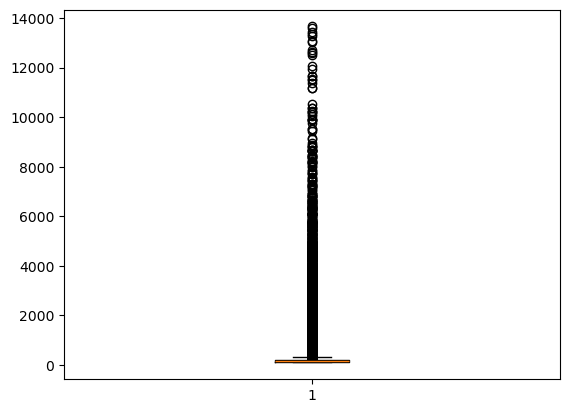

In [4]:
%matplotlib inline
data_high = data.loc[data['Value'] > 100]
print("Flitered points count: " + str(len(data_high)))
plt.boxplot(data_high['Value'])
plt.show()

原射线坐标系原生转换三维坐标系

In [5]:
def to3dAxes(frame, beam, point, reflection = True):
    x = frame * scanStep
    angleBeam = (angleStart + angleStep * beam) * math.pi / 180
    pointLen = detectLen * (point + 1) / pointCnt
    z = pointLen * np.sin(angleBeam)
    yFull = pointLen * np.cos(angleBeam)
    y = yFull
    if reflection == True:
        y = y % (2 * height)
        y[y > height] = 2 * height - y[y > height]
    return x, y, z



x, y, z = to3dAxes(data['Frame'].values, data['Beam'].values, data['Point'].values, reflection=False)
v = data['Value'].values
data_3d = pd.DataFrame({'x': x, 'y': y, 'z': z, 'value': v})
print(data_3d)
print(data_3d["value"].max())

           x          y          z  value
0          0   0.085915   0.060159     22
1          0   0.171831   0.120317     38
2          0   0.257746   0.180476     50
3          0   0.343661   0.240634     39
4          0   0.429577   0.300793     14
...      ...        ...        ...    ...
4917019  270  17.936088  49.278997    122
4917020  270  17.971960  49.377555     47
4917021  270  18.007833  49.476113     90
4917022  270  18.043705  49.574671    157
4917023  270  18.079577  49.673229    100

[4917024 rows x 4 columns]
13661


插值到点阵结构

In [6]:
%matplotlib inline
from scipy.interpolate import LinearNDInterpolator
from matplotlib.colors import LinearSegmentedColormap

def getGrid2D():
    axis = np.linspace(0, detectLen, num=gridn)
    return np.meshgrid(axis, axis)

def toGridData2D(y, z, value):
    # 生成对应grid数据
    yi = np.linspace(0, detectLen, num=gridn)
    zi = np.linspace(0, detectLen, num=gridn)
    yi, zi = np.meshgrid(yi, zi)
    interp = LinearNDInterpolator(list(zip(y, z)), value, fill_value=0)
    valuei = interp(yi, zi)
    return yi, zi, valuei

def drawAScan(x2d, y2d, value2d):
    my_color = [(0,'#FFFFFF'),(0.33,'#0000FF'),(0.66,'#00FF00'),(1,'#FF0000')]
    my_cmap = LinearSegmentedColormap.from_list('my_cmap', my_color)
    fig, ax = plt.figure(), plt.axes()
    im = ax.pcolormesh(x2d, y2d, value2d, shading='auto', cmap=my_cmap)
    ax.set(xlim=(0, detectLen), ylim=(0, detectLen))
    ax.invert_yaxis()
    fig.colorbar(im)
    plt.show(block=True)



# numpy 按frame存储的矩阵数组
data_clips = []

for frame in range(max(data_3d['x'].values) + 1):
    data_3df = data_3d.loc[data_3d['x']==frame, ['y', 'z', 'value']]
    yf, zf, vf = data_3df['y'].values, data_3df['z'].values, data_3df['value'].values
    yf_g, zf_g, vf_g = toGridData2D(yf, zf, vf)
    #drawAScan(zf_g, yf_g, vf_g)
    data_clips.append(np.array(vf_g))
    print("\rcurrent frame: {}".format(frame), end="")

print(len(data_clips))

current frame: 270271


均值衰减过滤结构噪声

[[   0.            0.            0.         ...    0.
     0.            0.        ]
 [   0.          699.30130954    0.         ...    0.
     0.            0.        ]
 [   0.         2025.28886453  482.77686163 ...    0.
     0.            0.        ]
 ...
 [   0.            0.            0.         ...    0.
     0.            0.        ]
 [   0.            0.            0.         ...    0.
     0.            0.        ]
 [   0.            0.            0.         ...    0.
     0.            0.        ]]


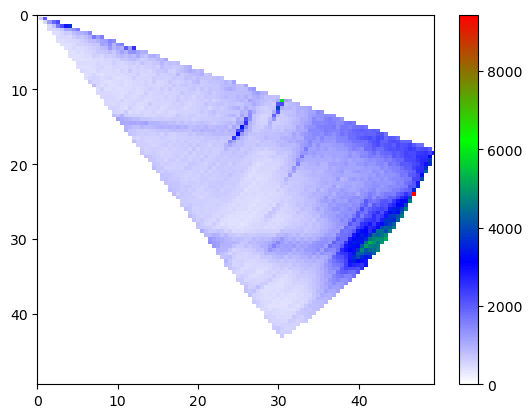

In [7]:
def reductMean(matrixArr, a=0.9):
    if len(matrixArr) == 0:
        return None
    mean = np.zeros_like(matrixArr[0])
    reduc = np.zeros_like(matrixArr[0])
    for matrix in matrixArr:
        reduc = reduc * a + matrix
        mean = mean + reduc
    mean = mean / len(matrixArr)
    return mean



meanFrame = reductMean(data_clips)
print(meanFrame)
gridY, gridZ = getGrid2D()
drawAScan(gridZ, gridY, meanFrame)

可视化三维散点图像

In [92]:
# TODO
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def feature_normalization(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    return (X-mu)/sigma

def cluster_kmeans(X, cluster_num, kdefault:any):
    """_summary_

    Args:
        X (_type_): data to be clustered
        cluster_num (_type_): maximum number of clusters
        kdefault (any)
    """
    X_norm = feature_normalization(X)
    if kdefault:
        best = kdefault
    else:
        score = []
        for i in range(2, cluster_num+1,1):
            cluster = i
            clf = KMeans(n_clusters=cluster)
            clf.fit(X_norm)
            label = clf.fit_predict(X_norm)
            score.append(silhouette_score(X_norm, clf.labels_, metric='euclidean'))
        print(score)
        best = score.index(max(score))+2
    print("best number of cluster is:", best)
    Cluster = KMeans(n_clusters=best)
    Cluster.fit(X_norm)
    label = Cluster.fit_predict(X_norm)
    defect_pd = pd.DataFrame(X, columns=["x", "y", "z"])
    defect_pd["label"] = np.array(label)
    return defect_pd
    
def FramePlot(ax3d, defect:defect):
    xmin, xmax, ymin, ymax, zmin, zmax = defect.xmin, defect.xmax, defect.ymin, defect.ymax, defect.zmin, defect.zmax
    ax3d.plot([xmin, xmax], [ymin, ymin], [zmin, zmin], c='r', linestyle='-', zorder=1)
    ax3d.plot([xmin, xmax], [ymax, ymax], [zmin, zmin], c='r', linestyle='-', zorder=1)
    ax3d.plot([xmin, xmax], [ymin, ymin], [zmax, zmax], c='r', linestyle='-', zorder=1)
    ax3d.plot([xmin, xmax], [ymax, ymax], [zmax, zmax], c='r', linestyle='-', zorder=1)
    ax3d.plot([xmin, xmin], [ymin, ymax], [zmin, zmin], c='r', linestyle='-', zorder=1)
    ax3d.plot([xmin, xmin], [ymin, ymax], [zmax, zmax], c='r', linestyle='-', zorder=1)
    ax3d.plot([xmax, xmax], [ymin, ymax], [zmin, zmin], c='r', linestyle='-', zorder=1)
    ax3d.plot([xmax, xmax], [ymin, ymax], [zmax, zmax], c='r', linestyle='-', zorder=1)
    ax3d.plot([xmin, xmin], [ymin, ymin], [zmin, zmax], c='r', linestyle='-', zorder=1)
    ax3d.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], c='r', linestyle='-', zorder=1)
    ax3d.plot([xmax, xmax], [ymax, ymax], [zmin, zmax], c='r', linestyle='-', zorder=1)
    ax3d.plot([xmin, xmin], [ymax, ymax], [zmin, zmax], c='r', linestyle='-', zorder=1)

def ThreeDplot(defect_list):
    fig = plt.figure(figsize=(20, 20))
    ax3d = fig.add_axes(Axes3D(fig))
    for defect in defect_list:
        shape = defect.point.shape
        for i in range(shape[0]):
            x = defect.point[i][0]
            y = defect.point[i][1]
            z = defect.point[i][2]
            ax3d.scatter(x, y, z, s=5, c=color[defect.label])
        FramePlot(ax3d, defect)
    ax3d.set_xlabel('X label') # 画出坐标轴
    ax3d.set_ylabel('Y label')
    ax3d.set_zlabel('Z label')
    plt.show()



  
    



In [93]:
x = data_3d.loc[(data_3d["value"]>4000), ["x", "y", "z"]].to_numpy()

Kmeans_results = cluster_kmeans(x, 10, None)
print(Kmeans_results)
num_cluster = np.max(Kmeans_results["label"].values) + 1


[0.672487521216454, 0.908740229196598, 0.9165372937350473, 0.6721994688584996, 0.5961191427460636, 0.5518018142379519, 0.5427339089823453, 0.46413192342869003, 0.5194135114371199]
best number of cluster is: 4
         x          y          z  label
0     58.0  11.120375  30.552978      0
1     59.0  12.179884  30.146271      0
2     59.0  11.651904  30.354248      0
3     59.0  11.689491  30.452165      0
4     59.0  11.084503  30.454420      0
..     ...        ...        ...    ...
328  227.0  23.950842  47.006175      2
329  227.0  23.998458  47.099626      2
330  228.0  23.950842  47.006175      2
331  228.0  23.998458  47.099626      2
332  229.0  23.998458  47.099626      2

[333 rows x 4 columns]


### using silhouette method to justify which k is best

        x        y        z
0    58.0  11.1204  30.5530
1    59.0  12.1799  30.1463
2    59.0  11.6519  30.3542
3    59.0  11.6895  30.4522
4    59.0  11.0845  30.4544
..    ...      ...      ...
172  72.0  11.6143  30.2563
173  72.0  11.6519  30.3542
174  72.0  11.0845  30.4544
175  72.0  11.1204  30.5530
176  73.0  11.0845  30.4544

[177 rows x 3 columns]
73.0 13.1819 30.7501 58.0 11.0486 29.607
         x        y        z
0    188.0  15.6179  24.9938
1    188.0  15.1793  25.2626
2    188.0  14.7361  25.5237
3    189.0  15.6179  24.9938
4    189.0  15.1793  25.2626
..     ...      ...      ...
98   200.0  15.7290  25.1717
99   200.0  15.2333  25.3525
100  200.0  15.2873  25.4424
101  200.0  14.7885  25.6145
102  200.0  14.8410  25.7053

[103 rows x 3 columns]
200.0 16.5393 26.115 188.0 13.8856 24.5205
        x        y        z
0   201.0  23.9985  47.0996
1   202.0  23.9508  47.0062
2   202.0  23.9985  47.0996
3   203.0  23.9508  47.0062
4   203.0  23.9985  47.0996
5   204.0  23.95

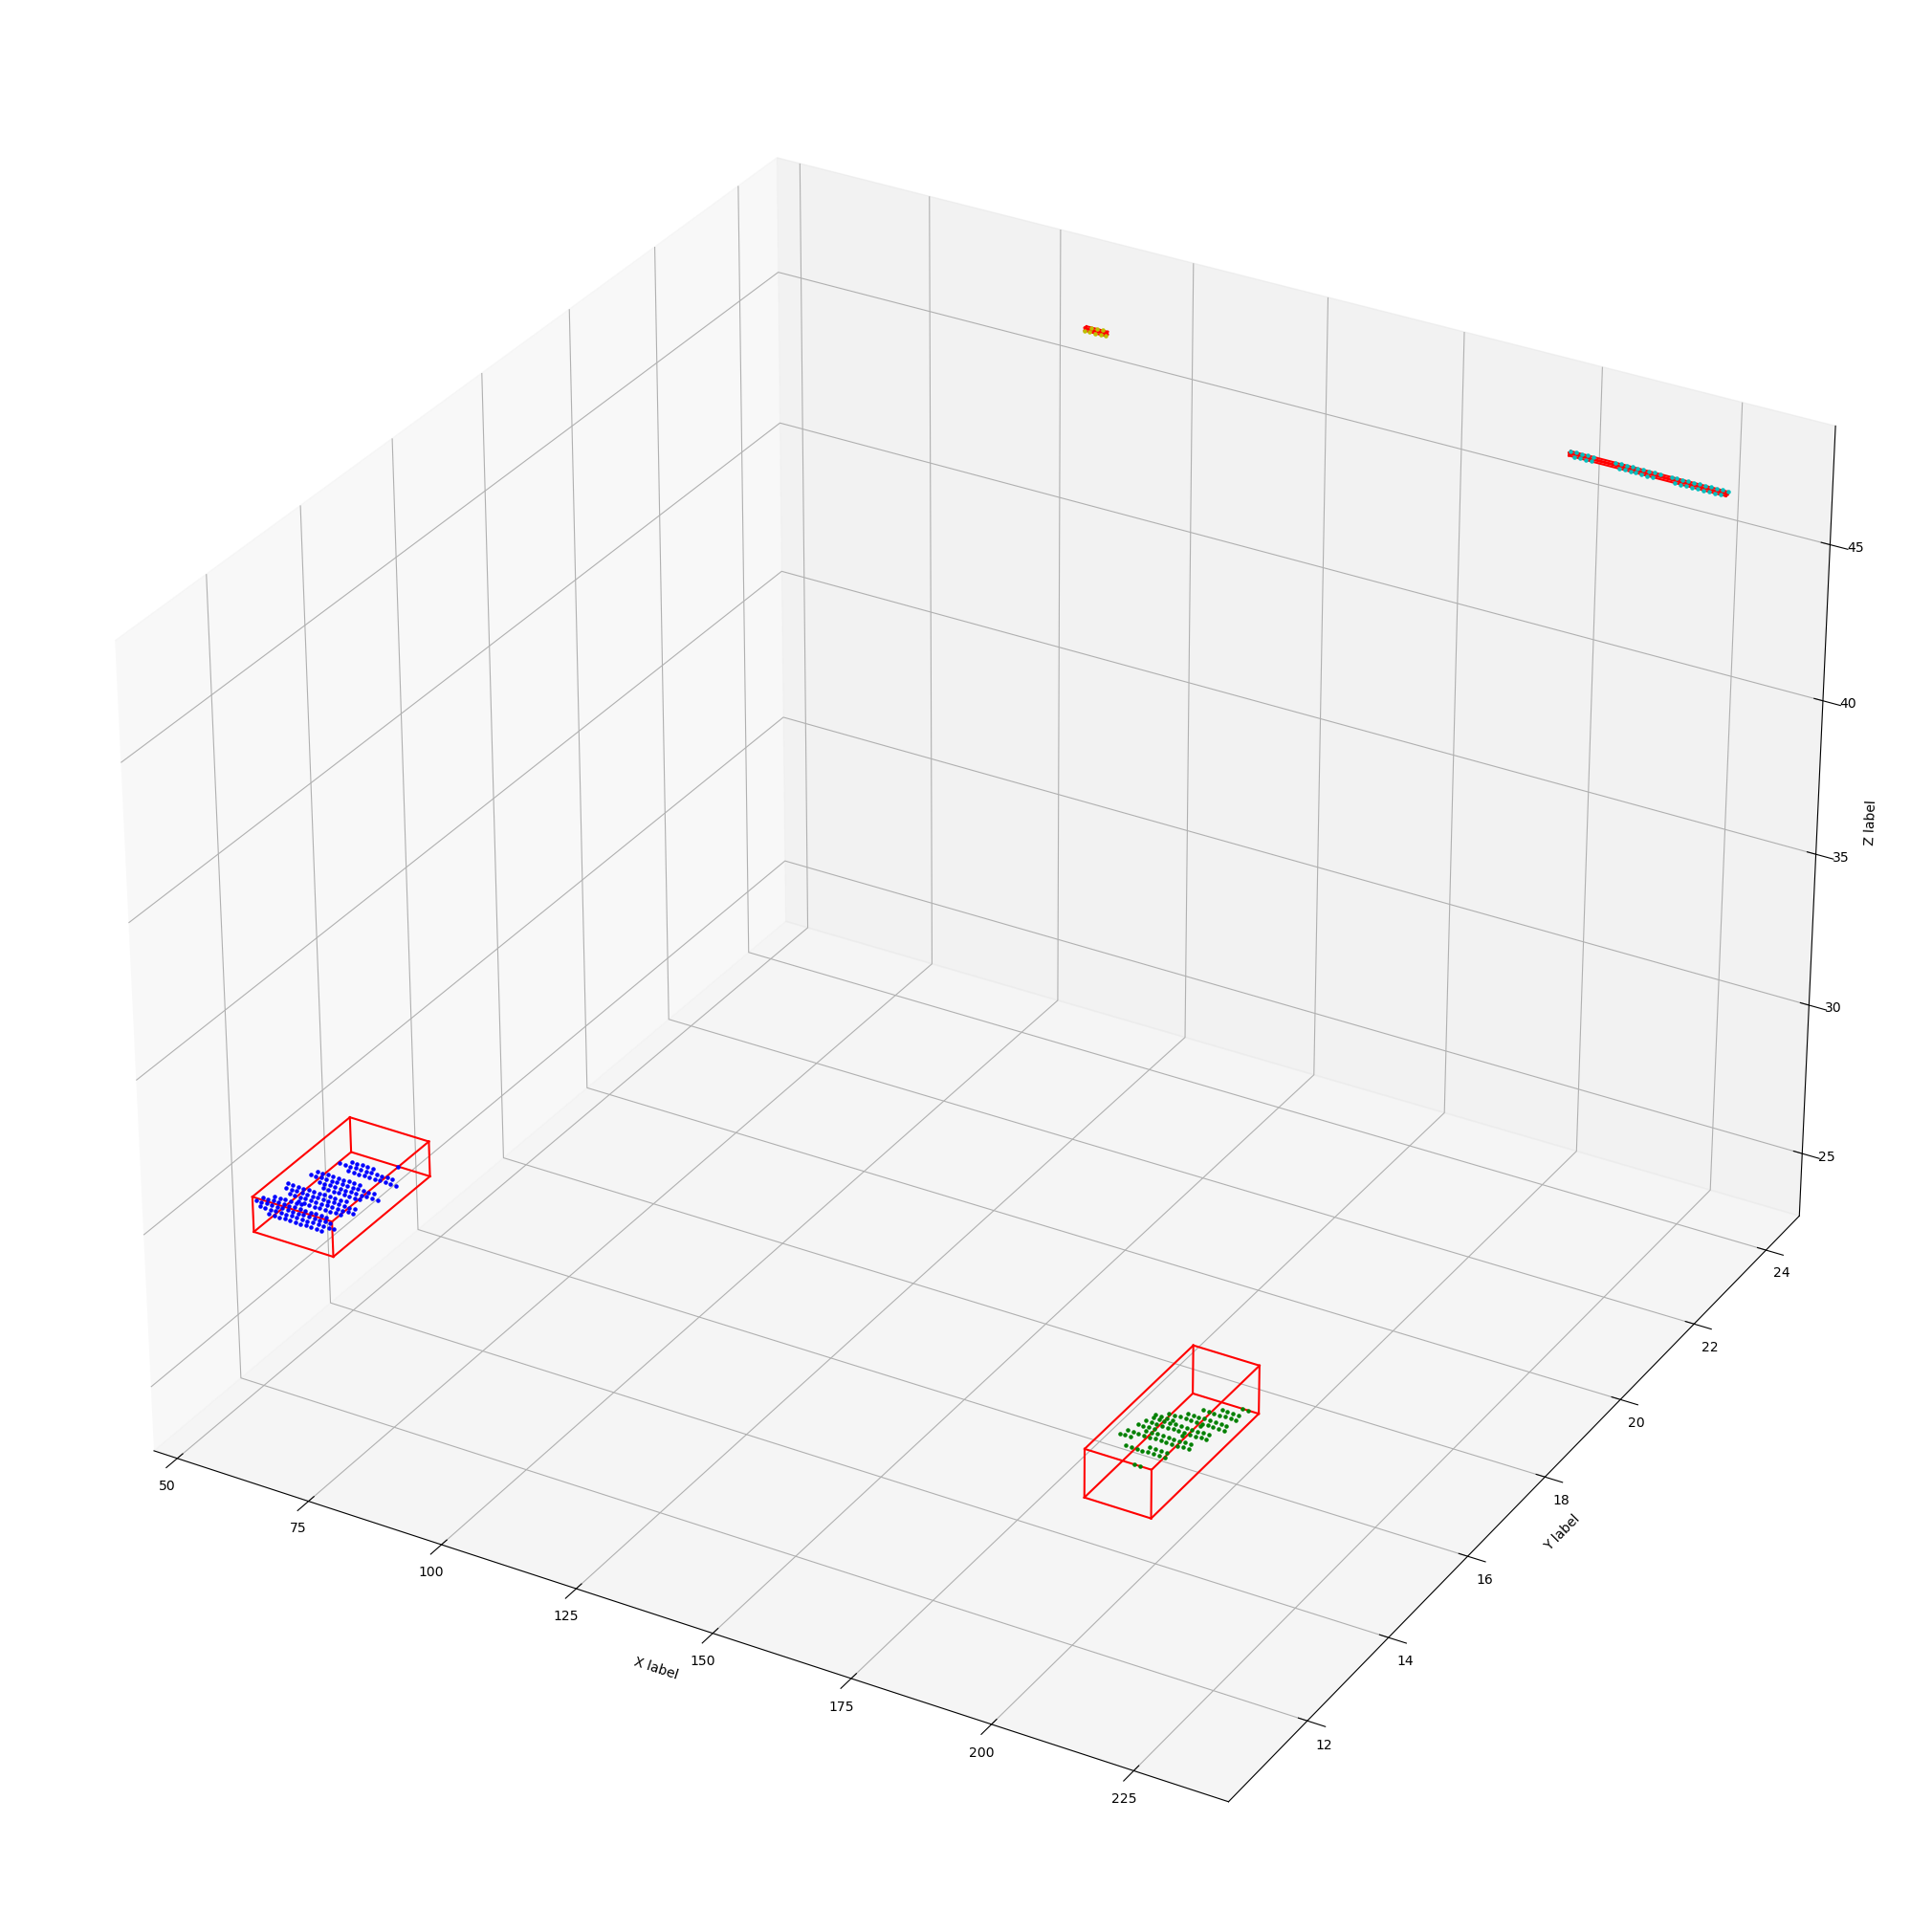

In [94]:
%matplotlib inline
Kcluster = []
for i in range(num_cluster):
    # print( Kmeans_results["label" == i])
    Kcluster.append(defect(np.array(Kmeans_results[Kmeans_results["label"] == i].drop(columns=["label"]).values), i))

ThreeDplot(Kcluster)
